In [1]:
import sys
import subprocess
import os
import glob
import numpy as np
import pandas as pd
import altair as alt
from PIL import Image

from gcnSurrogate.models.feastnetSurrogateModel import FeaStNet
from gcnSurrogate.readers.loadConmechGraphs import loadConmechGraphs
from gcnSurrogate.visualization.altTrussViz import plotTruss, interactiveErrorPlot
from gcnSurrogate.util.gcnSurrogateUtil import *

def arial():
    return {
        "config" : {
             "title": {'font': 'Arial'},
             "axis": {
                  "labelFont": 'Arial',
                  "titleFont": 'Arial'
             }
        }
    }

alt.themes.register('arial', arial)
alt.themes.enable('arial')

COLW = 3.5625*500

In [2]:
import shutil
from svgutils.compose import Unit
import svgutils.transform as sg
from collections.abc import Iterable 

def saveAsImage(fig, imgFile, widthInches=3.25, dpi=500, tempFile='figures/temp.png'):
    fig.save(tempFile, scale_factor=1.0)
    img = Image.open(tempFile)
    fig.save(imgFile, scale_factor=widthInches*dpi/img.size[0])
    img2 = Image.open(imgFile)
    if os.path.exists(tempFile): os.remove(tempFile)
    print(f'image size: {img2.size}')
    return img2

def checkSize(fig, tempFile='figures/temp.png'):
    fig.save(tempFile, scale_factor=1.0)
    img = Image.open(tempFile)
    print(img.size)
    return img

def svgToPng(svgFile, pngFile):
    subprocess.call(['inkscape', '--export-png='+pngFile, svgFile])
    
def svgToEps(svgFile, epsFile):
    subprocess.call(['inkscape', '--export-eps='+epsFile, svgFile]) 

def chartsToFigure(chartData, figName, baseDir, canvasSize=[600, 400]):
    # create a fresh directory
    figDir = os.path.join(baseDir, figName)
    figSvg = os.path.join(figDir, figName+'.svg')
    if os.path.exists(figDir) and os.path.isdir(figDir):
        shutil.rmtree(figDir)
    os.mkdir(figDir)
    
    # single-chart figure: charts is just a single altair chart
    if not isinstance(chartData, Iterable):
        chartData.save(figSvg, scale_factor=1.0)
        
    # multi-chart figure: chart data is a collection of charts and positions
    else:
        fig = sg.SVGFigure(Unit(canvasSize[0]), Unit(canvasSize[1]))
        
        for i,(chart,pos) in enumerate(chartData):
            chartSvg = os.path.join(figDir, f'{i}.svg')
            chart.save(chartSvg, scale_factor=1.0)
            p = sg.fromfile(chartSvg).getroot()
            p.moveto(pos[0],pos[1])
            fig.append(p)
    
        fig.save(figSvg)
    
    # export in desired file formats
    figPng = os.path.join(baseDir, figName+'.png')
    svgToPng(figSvg, figPng)
#     figEps = os.path.join(baseDir, figName+'.eps')
#     svgToEps(figSvg, figEps)
    
    # return image 
    img = Image.open(figPng)
    print(img.size)
    img.thumbnail([i/4 for i in img.size])
    return img

# correct sizing tests - concatenated plots

(1781, 1781)


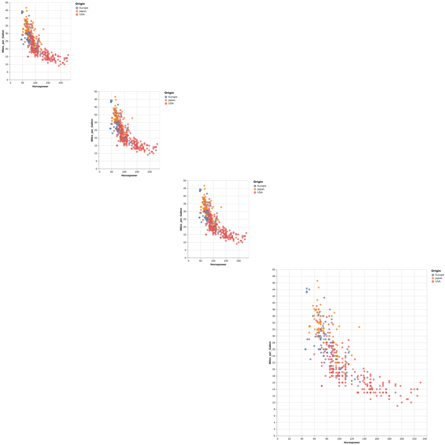

In [3]:
from vega_datasets import data
source = data.cars()

w = COLW/5 # five plots

# build charts
c1 = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('Horsepower', ),
    y='Miles_per_Gallon',
    color=alt.Color('Origin'),
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).properties(width=2*w, height=2*w)
c1.autosize = autosize=alt.AutoSizeParams(contains='padding', type='fit')

c2 = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('Horsepower', ),
    y='Miles_per_Gallon',
    color=alt.Color('Origin'),
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).properties(width=w, height=w)
c2.autosize = alt.AutoSizeParams(contains='padding', type='fit')

# build figure
chartData = [[c2,[w*i,w*i]] for i in range(3)]
chartData.append([c1, [w*3,w*3]])
chartsToFigure(chartData, figName='myFig01', baseDir='figures', canvasSize=[COLW, COLW])

30000.0
(1781, 1318)


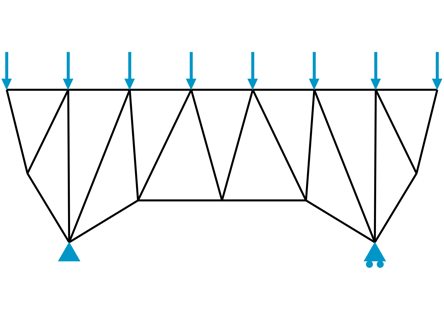

In [8]:
allGraphs = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/')
truss = plotTruss(allGraphs[0], width=COLW, lineWidth=8, showSupports=True, showLoads=True, loadSize=1e4, supportSize=3e4, domY=[-27,10])
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='truss', baseDir='figures')

(1781, 1318)


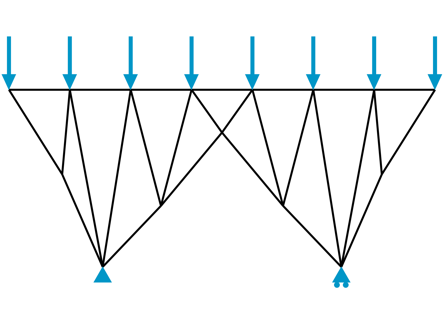

In [168]:
# color = '#0096C7'
# size = 20000
# graph = allGraphs[0]

# posxdf = pd.DataFrame(np.hstack([graph.pos,graph.x]), columns=['x','y','sx','sy', 'load'])

# # pins
# wt = 0.5
# ht = 0.866
# triangleSvg = f"M 0 0 L {wt} {ht} L {-wt} {ht} Z "
# pinChart = alt.Chart(posxdf.loc[(posxdf.sx==1) & (posxdf.sy==1)]).mark_point(
#     shape=triangleSvg, 
#     fill=color, 
#     stroke=color, 
#     opacity=1.0, 
#     size=size).encode(x='x', y='y')

# # x-rollers
# r = 0.15
# w = 0.25
# y = ht+r
# c = 0.05
# rollerSvg = f"""M 0 0 L {wt} {ht} L {-wt} {ht} Z 
#                     M{w-r},{y} A{c},{c},0,0,1,{w+r},{y}A{c},{c},0,1,1,{w-r},{y} 
#                     M{-w-r},{y} A{c},{c},0,0,1,{-w+r},{y} A{c},{c},0,1,1,{-w-r},{y}"""
# rollerXChart = alt.Chart(posxdf.loc[(posxdf.sx==0) & (posxdf.sy==1)]).mark_point(
#     shape=rollerSvg, 
#     fill=color, 
#     stroke=color, 
#     opacity=1.0, 
#     size=size).encode(x='x', y='y')

# # downward-loads

# L=3
# w=0.1
# theta=-90

# arPts = np.array([[0.0, 0.0], 
#                    [-4*w, -np.sqrt(3.0)/2.0], 
#                    [-w, -np.sqrt(3.0)/2.0], 
#                    [-w, -L], 
#                    [w, -L], 
#                    [w, -np.sqrt(3.0)/2.0], 
#                    [4*w, -np.sqrt(3.0)/2.0]])

# # rotate
# theta = np.radians(theta)+np.pi/2
# c, s = np.cos(theta), np.sin(theta)
# R = np.array(((c, -s), (s, c)))
# arPts = np.matmul(arPts,R) 

# dForceChart = alt.Chart(posxdf.loc[posxdf.load!=0]).mark_point(
#     shape=polylineToSvg(arPts), 
#     fill=color, 
#     stroke=color, 
#     opacity=1.0, 
#     size=size).encode(x='x', y='y')

# truss = plotTruss(graph, 
#                   width=COLW, 
#                   lineWidth=8, 
#                   showSupports=False, 
#                   showLoads=False, 
#                   domY=[-27,10], 
#                   showAxis=False, 
#                   withoutConfigure=True)

# chartData = alt.layer(truss, pinChart, rollerXChart, dForceChart).configure_view(strokeOpacity=0)
# chartData.autosize = alt.AutoSizeParams(contains='padding', type='fit')
# chartsToFigure(chartData, figName='myFig08', baseDir='figures')

In [1]:
# L=3
# w=0.1
# theta=-90

# arPts = np.array([[0.0, 0.0], 
#                    [-4*w, -np.sqrt(3.0)/2.0], 
#                    [-w, -np.sqrt(3.0)/2.0], 
#                    [-w, -L], 
#                    [w, -L], 
#                    [w, -np.sqrt(3.0)/2.0], 
#                    [4*w, -np.sqrt(3.0)/2.0]])

# def polylineToSvg(coords):
#     return 'M'+' '.join([f'L {i} {j}' for i,j in coords])[1:]
# polylineToSvg(arPts)

# Design space and loading conditions

(600, 270)


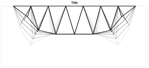

In [10]:
domX = [-5,55]
domY = [-20-pad,0]
opacities = np.linspace(0.1,0.6,5)
opacities[-1] = 1
plotList = [plotTruss(g, withoutConfigure=True, 
                      lineOpacity=o, 
                      baseColor='#000000',
                      domX=domX, 
                      domY=domY, 
            width=width) for g,o in zip(allGraphs, opacities)]
chartData = alt.layer(*plotList, title='Title')
chartData.autosize=alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(chartData, figName='myFig03', baseDir='figures')

In [ ]:
alt.themes.enable('none')
sweepDirs = glob.glob('data/2D_Truss_v1.3/conmech/param_sweep*/')
width = 600
pad = 7
domX = [-5,55]
domY = [-20-pad,0]

sweepPlotList = []
for i,dataDir in enumerate(np.sort(sweepDirs)):
    print(f'loading from {dataDir}')
    allGraphs = loadConmechGraphs(dataDir)
    
    if i==4: domY = [-20,0]

    opacities = np.linspace(0.1,0.6,5)
    opacities[-1] = 1
    plotList = [plotTruss(g, withoutConfigure=True, 
                          lineOpacity=o, 
                          baseColor='#000000',
                          domX=domX, 
                          domY=domY, 
                width=width) for g,o in zip(allGraphs, opacities)]
    sweepPlot = alt.layer(*plotList, title='Title')
    sweepPlotList.append(sweepPlot)
    
domY = [-20,0+pad]
nomDesign = plotTruss(allGraphs[2], 
                      withoutConfigure=True, 
                      domX=domX, 
                      domY=domY, 
                      width=width,
                      showLoads=True,
                      showSupports=True,
                      baseColor='#000000')

# build figure
chartData = [[c2,[w*i,w*i]] for i in range(3)]
chartData.append([c1, [w*3,w*3]])
chartsToFigure(chartData, figName='myFig01', baseDir='figures', canvasSize=[3.5625*500, 3.5625*500])

loading from data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_1_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_2_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_3_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_4_7_N_5/
image size: (1625, 1342)


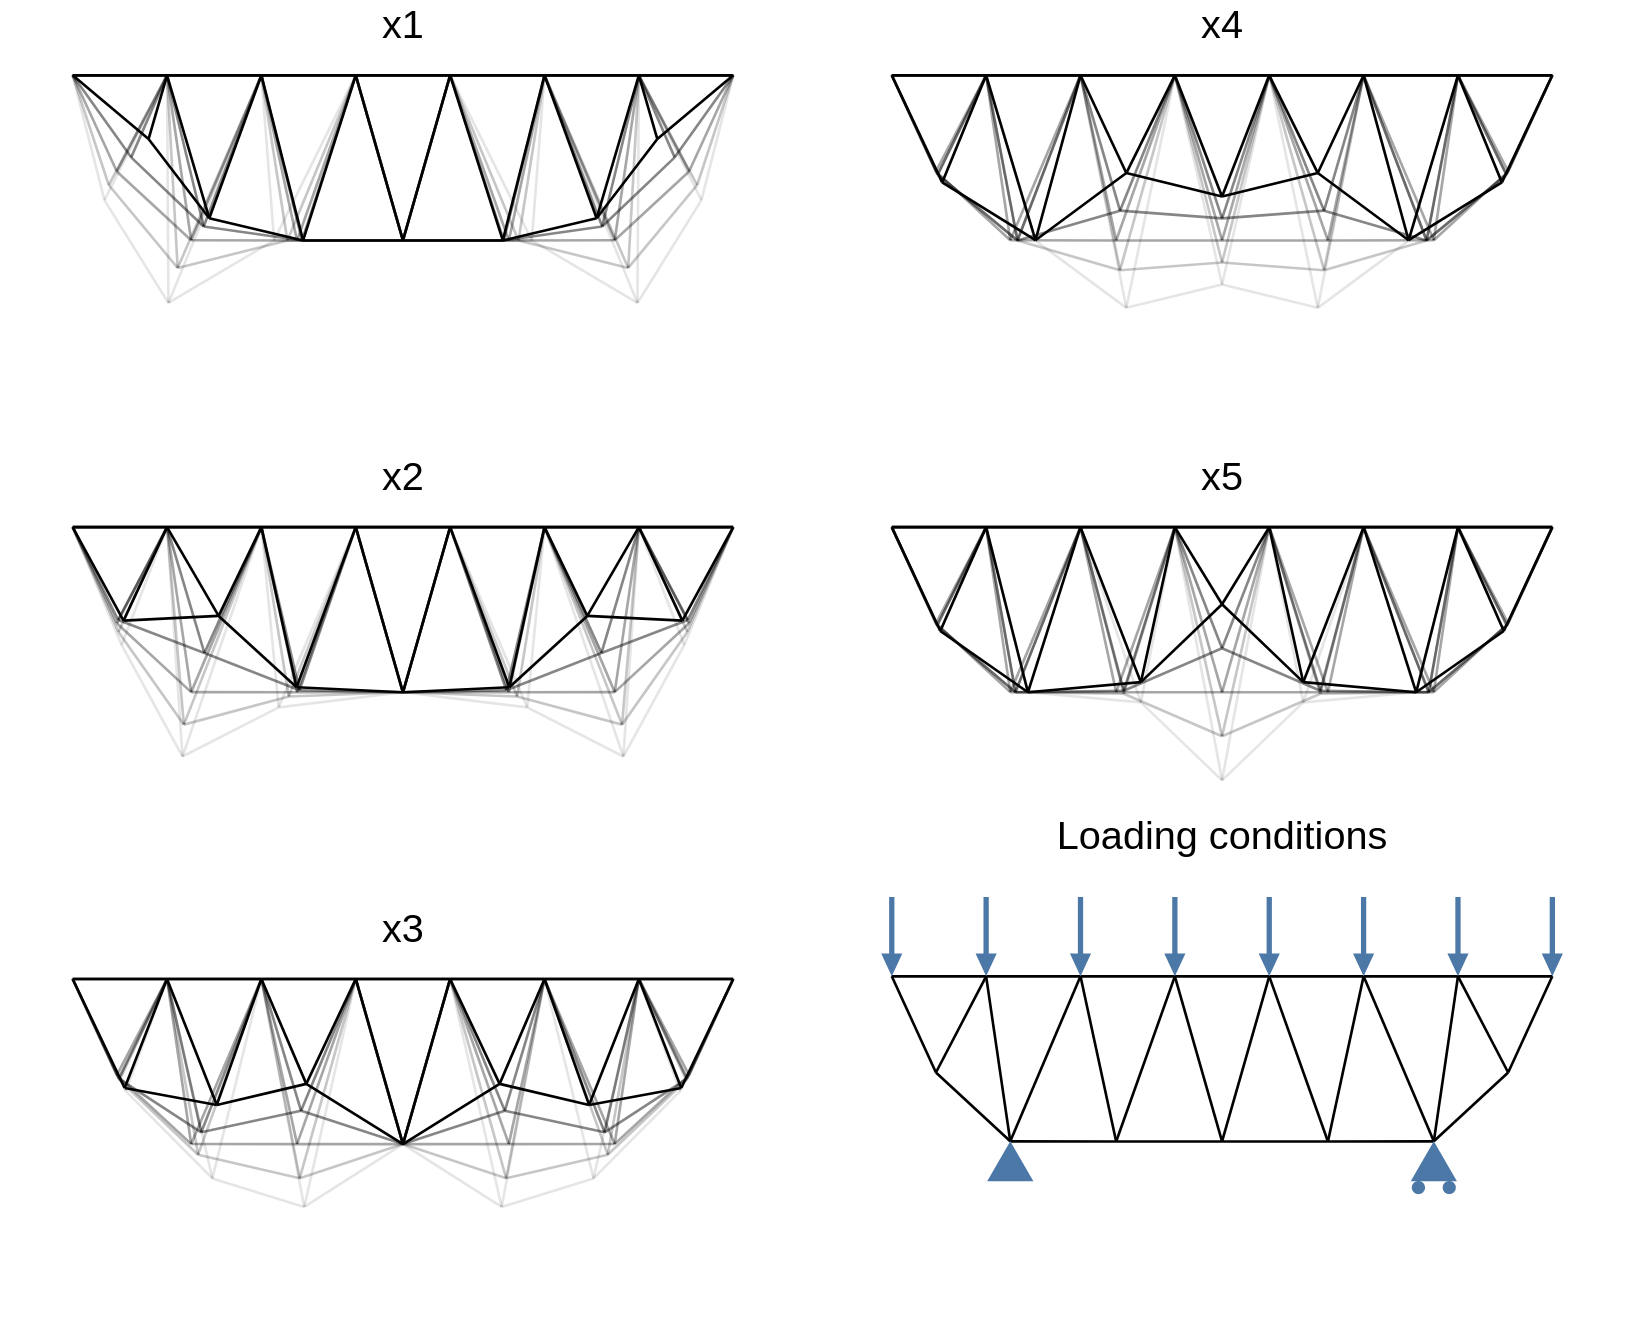

In [3]:
# alt.themes.enable('none')
# sweepDirs = glob.glob('data/2D_Truss_v1.3/conmech/param_sweep*/')
# width = 600
# pad = 7
# domX = [-5,55]
# domY = [-20-pad,0]

# sweepPlotList = []
# for i,dataDir in enumerate(np.sort(sweepDirs)):
#     print(f'loading from {dataDir}')
#     allGraphs = loadConmechGraphs(dataDir)
    
#     # make a title
#     title = alt.Chart(
#         {'values': [{"text": f'x{i+1}'}]}
#     ).mark_text(size=30, align='center', font='Arial').encode(
#         text="text:N"
#     ).properties(width=width)
#     sweepPlotList.append(title)
    
#     if i==4: domY = [-20,0]

#     opacities = np.linspace(0.1,0.6,5)
#     opacities[-1] = 1
#     plotList = [plotTruss(g, withoutConfigure=True, 
#                           lineOpacity=o, 
#                           baseColor='#000000',
#                           domX=domX, 
#                           domY=domY, 
#                 width=width) for g,o in zip(allGraphs, opacities)]
#     sweepPlot = alt.layer(*plotList)
#     sweepPlotList.append(sweepPlot)
    
# # make a title
# nomTitle = alt.Chart(
#     {'values': [{"text": f'Loading conditions'}]}
# ).mark_text(size=30, align='center', font='Arial').encode(
#     text="text:N"
# ).properties(width=width)
    
# domY = [-20,0+pad]
# nomDesign = plotTruss(allGraphs[2], 
#                       withoutConfigure=True, 
#                       domX=domX, 
#                       domY=domY, 
#                       width=width,
#                       showLoads=True,
#                       showSupports=True,
#                       baseColor='#000000')
    
# col0 = alt.vconcat(*sweepPlotList[:6])
# col1 = alt.vconcat(*sweepPlotList[6:],nomTitle,nomDesign)
# fig = alt.hconcat(col0, col1, background='white').configure_view(strokeOpacity=0)
# saveAsImage(fig, 'figures/desSpace.png', widthInches=3.25, dpi=500)

# Samples from a single group

In [7]:
# load data
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
allGraphsUnfiltered = loadConmechGraphs(dataDir)
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

allPts = np.concatenate([g.pos.numpy() for g in allGraphsUnfiltered])
print(np.min(allPts, axis=0))
print(np.max(allPts, axis=0))

[  0.  -24.5]
[50.  0.]


image size: (1625, 778)


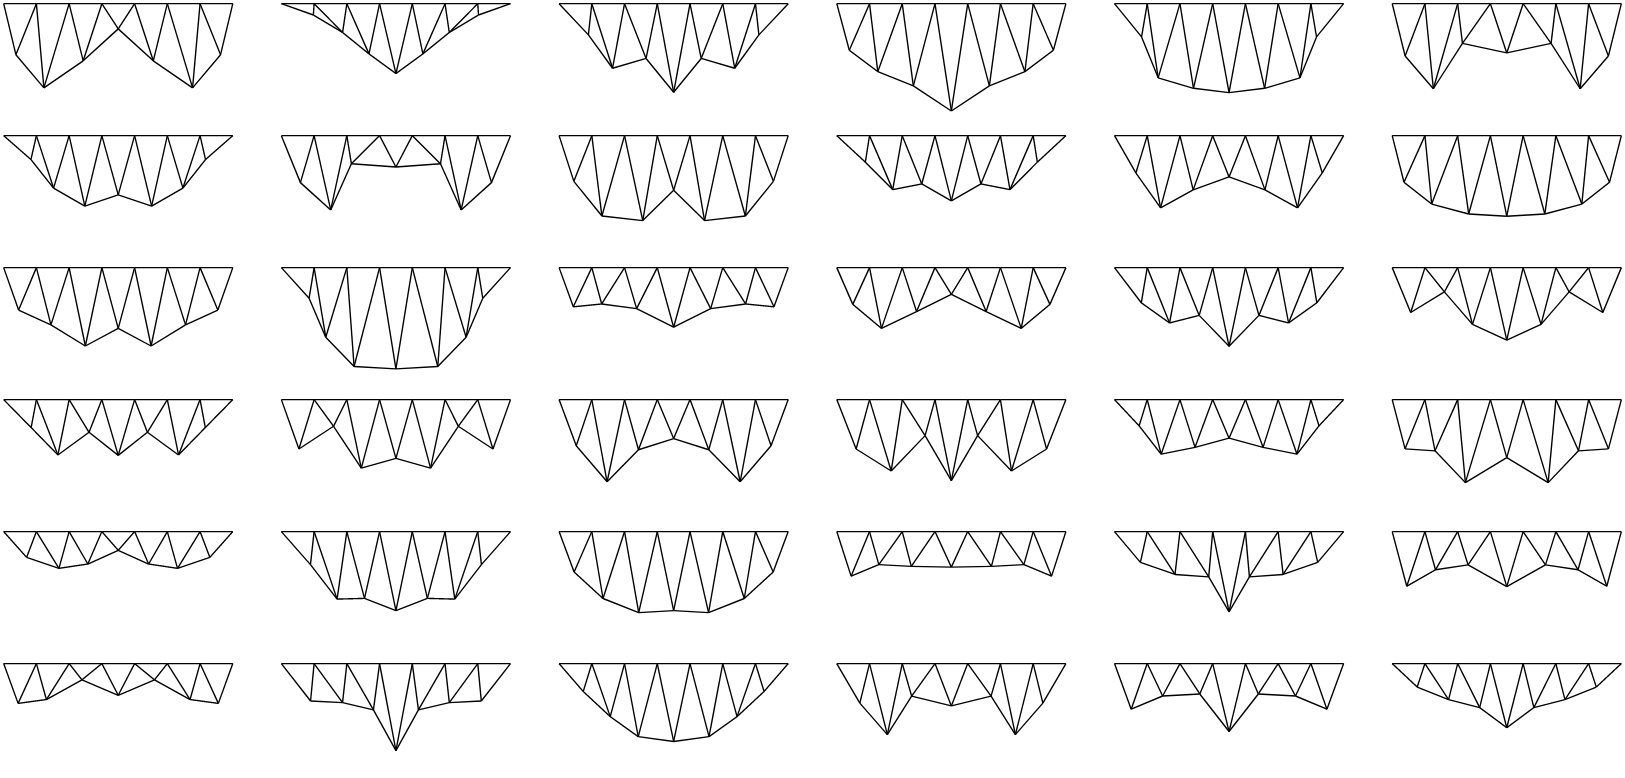

In [8]:
plotList = [plotTruss(g, 
                      width=500, 
                      domX=[0,50], 
                      domY=[-24.5,0], 
                      lineWidth=3, 
                      withoutConfigure=True, 
                      baseColor='#000000') for g in testData[:36]]
columnList = [alt.vconcat(*plotList[6*i:6*(i+1)], spacing=40) for i in range(6)]
fig = alt.hconcat(*columnList, spacing=100, background='white').configure_view(strokeOpacity=0)

saveAsImage(fig, 'figures/desing7Samples.png', widthInches=3.25, dpi=500)

# Error plot and sample predictions

In [81]:
# load model
gcn = FeaStNet()
gcn.loadModel('results/gcn01/checkpoint_94')

# load data
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
allGraphsUnfiltered = loadConmechGraphs(dataDir)
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

# run inference
predictions = gcn.predict(testData)
resultsDictWide = computeFieldLossMetrics([g.y.cpu().numpy() for g in testData], 
                              predictions, 
                              baselineRef=None, level='field')
resultsDict = [dict(zip(resultsDictWide,t)) for t in zip(*resultsDictWide.values())]
df = pd.DataFrame(resultsDict)

image size: (1625, 1006)


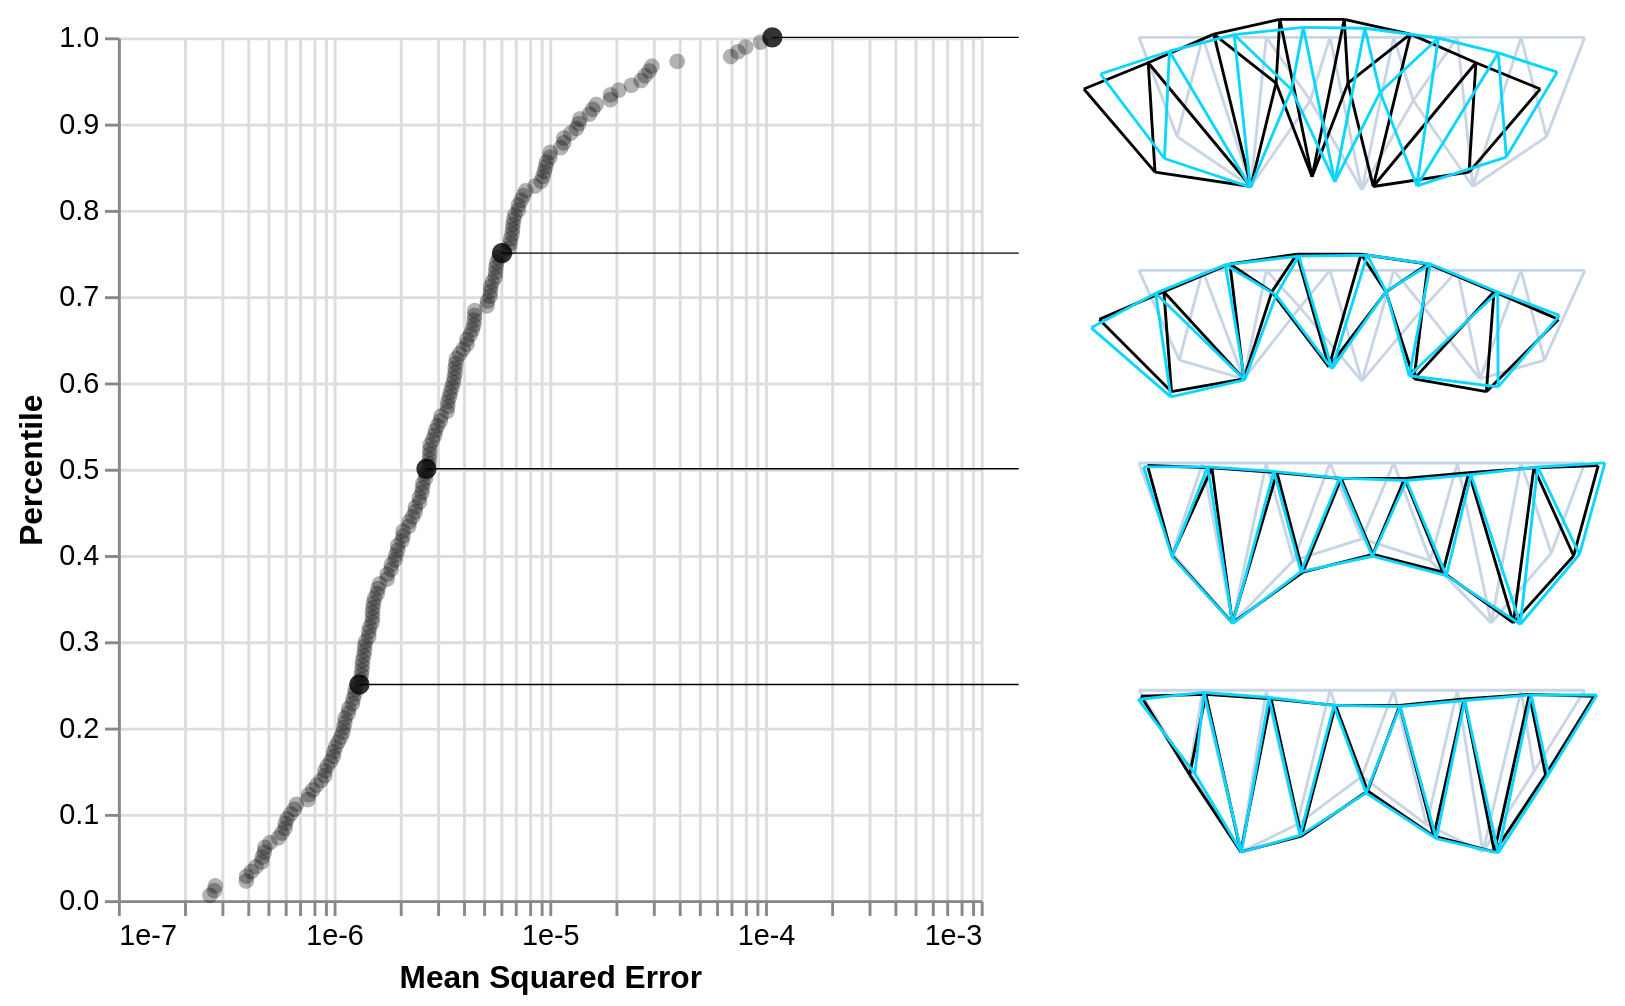

In [77]:
# make scatter plot
percentileList = [1.0, 0.75, 0.5, 0.25]
indices = [df[df.Percentile >= p].index[0] for p in percentileList]
mses = [df[df.Percentile >= p].mse.values[0] for p in percentileList]
df['selected'] = False
df.loc[indices,'selected'] = True

cdf = alt.Chart(df).mark_circle(color='#000000', opacity=0.3).encode(
    y=alt.Y('Percentile:Q', axis=alt.Axis(grid=True)),
    x=alt.X('mse:Q', scale=alt.Scale(type='log'), axis=alt.Axis(tickCount=5, format=".0e", grid=True), title='Mean Squared Error'),
    opacity=alt.Opacity('selected:N', legend=None),
    size=alt.Size('selected:N', legend=None, scale=alt.Scale(range=[30, 50]))
).properties(width=300, height=300)


# make lines
nLines = len(percentileList)
dfLines = pd.DataFrame({'line':np.linspace(0,nLines-1,num=nLines).repeat(2), 'point':['start', 'end']*len(percentileList)})
dfLines.loc[dfLines.point=='start', 'Percentile'] = percentileList
dfLines.loc[dfLines.point=='end', 'Percentile'] = percentileList #[0.98, 0.72, 0.46, 0.2]
dfLines.loc[dfLines.point=='end', 'x'] = 1.5e-3
dfLines.loc[dfLines.point=='start', 'x'] = mses

lineList = []
for i in range(nLines):
    line = alt.Chart(dfLines.loc[dfLines.line==i]).mark_line(color='#000000', strokeWidth=0.5).encode(
        alt.X('x:Q', scale=alt.Scale(domain=[1e-7,1e-3], nice=True, type='log')), 
        alt.Y('Percentile:Q'))
    lineList.append(line)
cdf = alt.layer(cdf, *lineList)

# make trusses
trussList = []
for p,i in zip(percentileList, indices):
    t = plotTruss(testData[i], 
                  showDeformed=True, 
                  prediction=predictions[i], 
                  defScale=200, 
                  withoutConfigure=True, 
                  baseColor='#000000',
                  width=155, 
                  lineWidth=1)
    trussList.append(t)
    
col0 = alt.vconcat(*trussList)

fig = alt.hconcat(cdf, col0).configure_view(strokeOpacity=0)
saveAsImage(fig, 'figures/errorPlots.png', widthInches=3.25, dpi=500)

In [85]:
# make scatter plot
df['Percentile'] = df['mae'].rank(pct=True)
df = df.sort_values(['Percentile'])
percentileList = [1.0, 0.75, 0.5, 0.25]
indices = [df[df.Percentile >= p].index[0] for p in percentileList]
mses = [df[df.Percentile >= p].mse.values[0] for p in percentileList]
df['selected'] = False
df.loc[indices,'selected'] = True

cdf = alt.Chart(df).mark_circle(color='#000000', opacity=0.3).encode(
    y=alt.Y('Percentile:Q', axis=alt.Axis(grid=True)),
    x=alt.X('mae:Q', scale=alt.Scale(type='linear'), axis=alt.Axis(tickCount=5, format=".0e", grid=True), title='Mean Absolute Error'),
    opacity=alt.Opacity('selected:N', legend=None),
    size=alt.Size('selected:N', legend=None, scale=alt.Scale(range=[30, 50]))
).properties(width=300, height=300)

cdf

alt.Chart(...)

In [92]:
alt.Chart(df).mark_bar().encode(
    alt.X("mae:Q", bin=alt.Bin(maxbins=30)),
    y='count()',
).properties(width=600, height=200)

alt.Chart(...)

# Comparison to pointwise regressor

In [7]:
dataDir = "data/2D_Truss_v1.3/conmech/"
trainDir = os.path.join(dataDir, 'design_7_N_1000_v2/')
allGraphsUnfiltered = loadConmechGraphs(trainDir)
trainData = filterbyDisp(allGraphsUnfiltered, 0.9)

testDir = os.path.join(dataDir, 'design_7_N_1000/')
allGraphsUnfiltered = loadConmechGraphs(testDir)
testData = filterbyDisp(allGraphsUnfiltered, 0.9)

base = baseline([g.y.cpu().numpy() for g in trainData], 
                [g.y.cpu().numpy() for g in testData], 
                level='set', avgLevel='point')
base

{'mse': 8.7927525e-05,
 'mae': 0.00593759,
 'mre': 0.26592276,
 'peakR2': -0.4423568113063039,
 'maxAggR2': 1.0,
 'meanAggR2': 0.09806866458510878,
 'minAggR2': -0.003530653230065628}

image size: (1625, 1009)


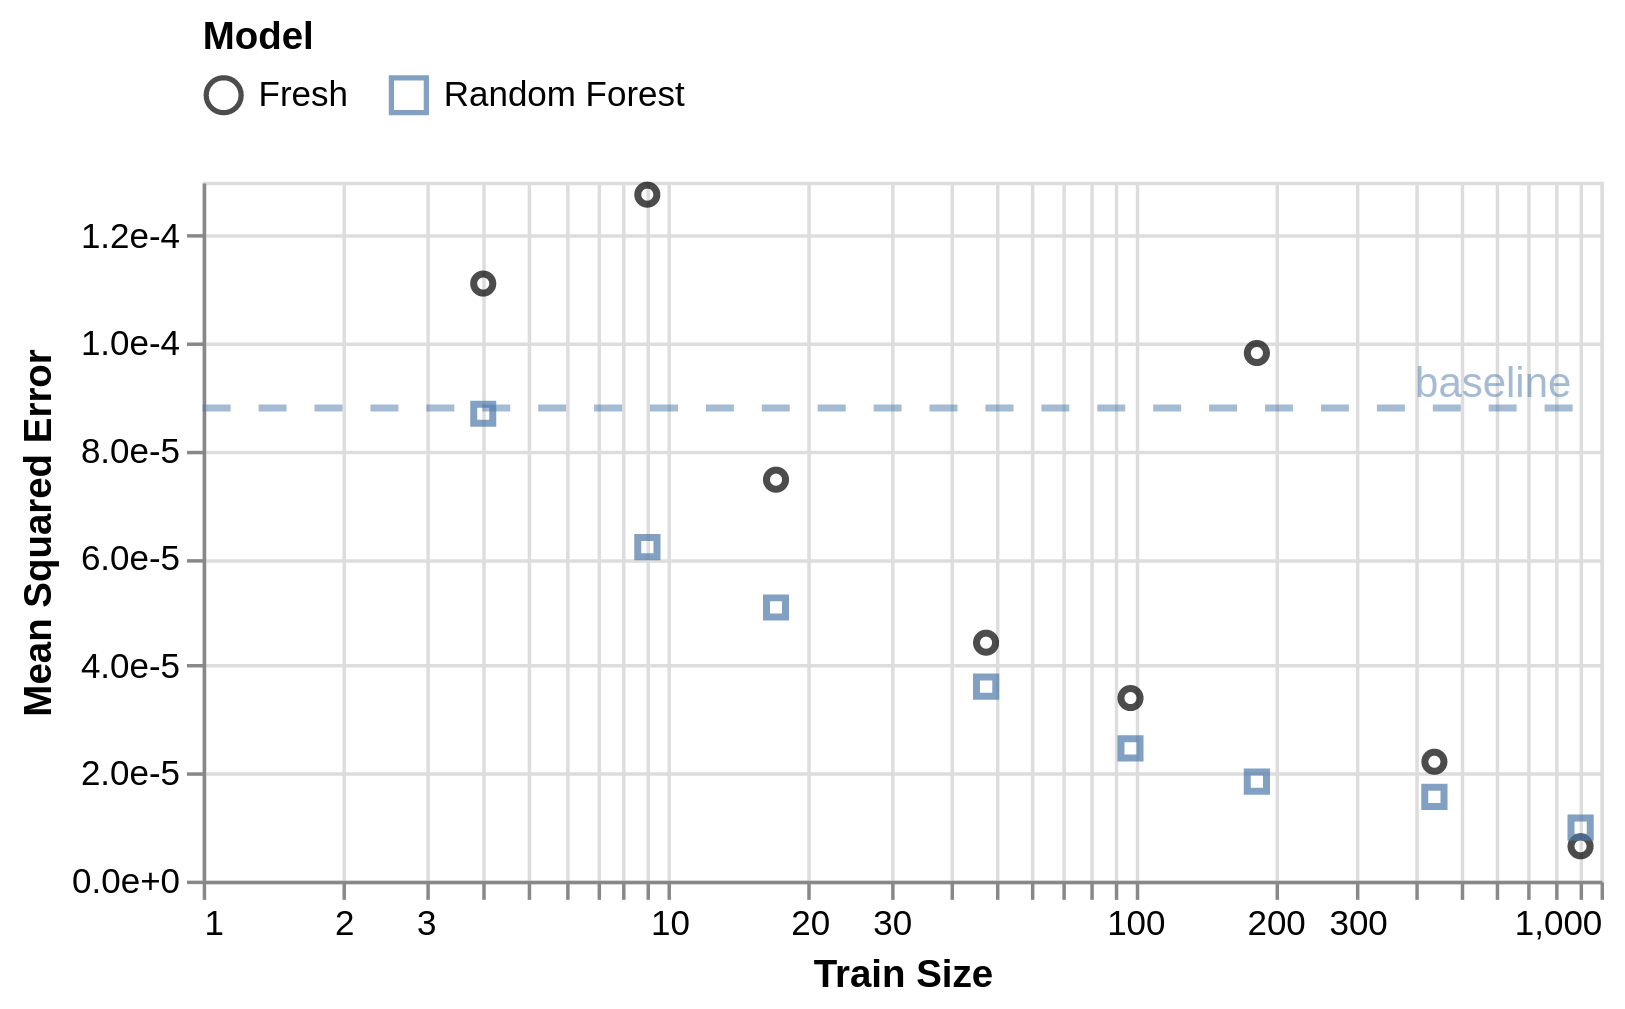

In [114]:
df = pd.read_csv('results/transferLrn_des7_03/testResults.csv')

fig = alt.Chart(df[(df.Set=='Test') & (df.Model!='Transfer learning')]).mark_point().encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
    color=alt.Color('Model', scale=alt.Scale(range=['#000000', '#4C78A8']), legend=alt.Legend(orient='top')),
    shape='Model',
    tooltip=['Model', 'mse']).properties(width=400, height=200)
    
baseline = alt.Chart(pd.DataFrame({'Train Size':[1,1000], 'mse':[base['mse']]*2})).mark_line(opacity=0.5, strokeDash=[8,8]).encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q'),
)

baselineLabel = alt.Chart(pd.DataFrame({"text": 'baseline', 'Train Size':400, 'mse':base['mse']}, index=[0])).mark_text(
    size=12, align='left', font='Arial', baseline='bottom', color='#4C78A8', opacity=0.5).encode(
    x='Train Size',
    y='mse',
    text="text:N"
).properties(width=width)

saveAsImage(fig+baseline+baselineLabel, 'figures/pointwiseRegCompDes7.png', widthInches=3.25, dpi=500)

# Samples from several groups

In [3]:
# load data
doeDirs = np.sort(glob.glob('data/2D_Truss_v1.3/conmech/*1000/'))
trainSets ,valSets ,testSets = {}, {}, {}
for doeDir in doeDirs:
    designName = doeDir.split('/')[-2].split('_N')[0]
    print(f'loading {designName}')
    allGraphsUnfiltered = loadConmechGraphs(doeDir)
    allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
    trainData, valData, testData = partitionGraphList(allGraphs)
    trainSets[designName] = trainData
    valSets[designName] = valData
    testSets[designName] = testData

loading design_5
loading design_6
loading design_7
loading design_8
loading design_9


image size: (1625, 1384)


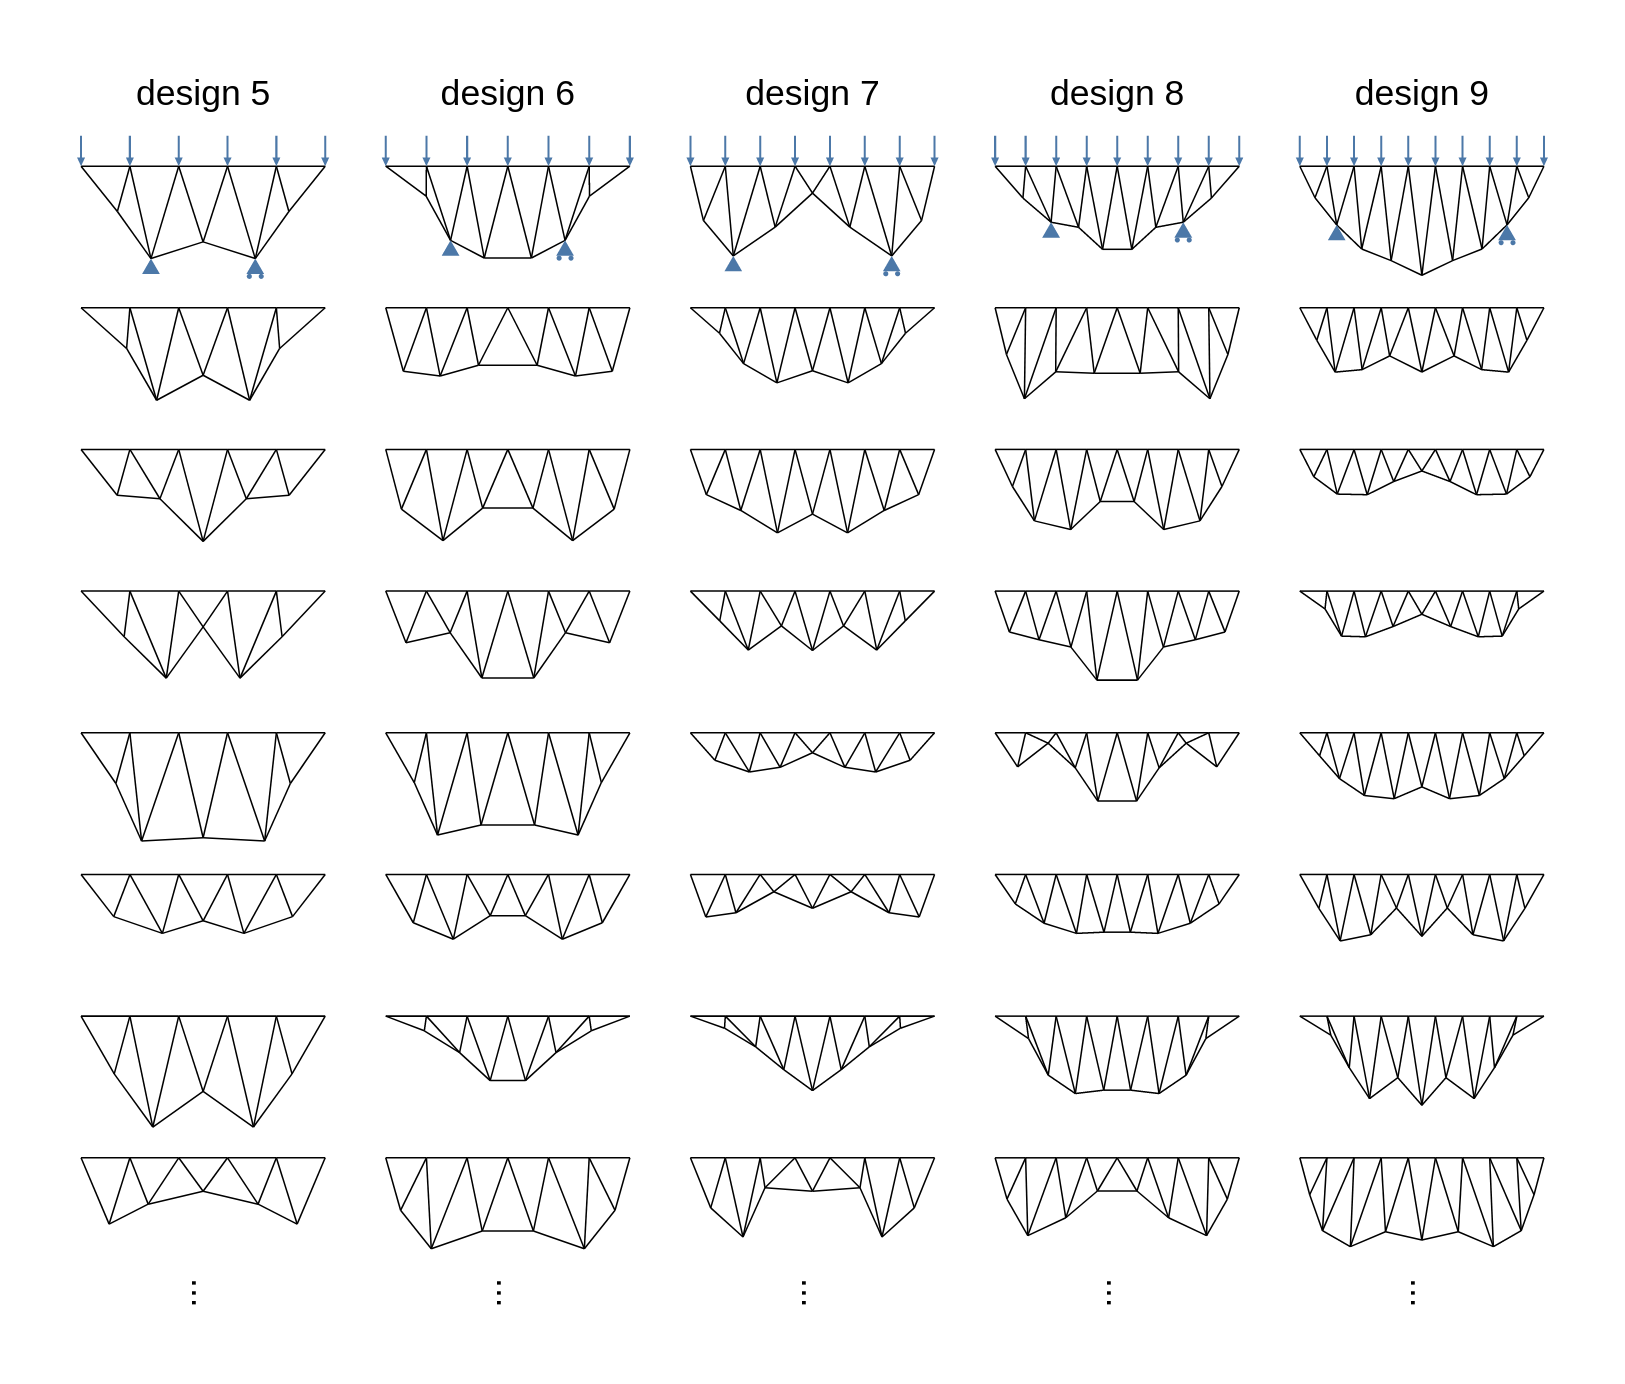

In [4]:
columnList = []
width = 500
pad = 150

# ellipses lables
ellipses = alt.Chart(
    {'values': [{"text": '...'}]}
).mark_text(size=70, align='center', font='Arial', angle=90).encode(
    text="text:N"
).properties(width=width)

for testName, testSet in testSets.items():
    # make labels
    title = alt.Chart(
        {'values': [{"text": testName.replace('_', ' ')}]}
    ).mark_text(size=70, align='center', font='Arial').encode(
        text="text:N"
    ).properties(width=width)
    
    plotList = []
    for i,g in enumerate(testSet[:8]):
        domY = [-24.5,0+7] if i==0 else [-24.5,0]
        plotList.append(plotTruss(g, 
                          width=width, 
                          domX=[-1,51], 
                          domY=domY, 
                          lineWidth=3,
                          showLoads=(i==0),
                          showSupports=(i==0),
                          withoutConfigure=True, 
                          baseColor='#000000'))
#     columnList.append(alt.vconcat(title, *plotList, spacing=40))
    col = alt.vconcat(title, *plotList, spacing=40)
    columnList.append(alt.vconcat(col, ellipses, spacing=0))
fig = alt.hconcat(*columnList, spacing=100, background='white').configure(
    padding={'top':pad, 'bottom':pad, 'left':pad, 'right':pad}
).configure_view(strokeOpacity=0)
saveAsImage(fig, 'figures/multigroupSamples.png', widthInches=3.25, dpi=500)

# Transfer learning study 1

In [124]:
df = pd.read_csv('results/topoTest04/testResults.csv')

order = ['test group', 'all groups']
barChart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mse):Q', axis=alt.Axis(tickCount=8, format=".0e"), title='MSE'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
    tooltip='mean(mse):Q'
).properties(width=75, height=200)

scatter = alt.Chart(df).mark_circle(size=20).encode(
    x=alt.X('Trained on:N', title='', sort=order),
    y=alt.Y('mse:Q'),
    color=alt.Color('Trained on:N', sort=order),
    opacity = alt.OpacityValue(0.3),
    tooltip='mse:Q'
)

alt.layer(barChart, scatter, data=df).facet(
    column=alt.Column('Tested on:N'))

alt.FacetChart(...)

image size: (1625, 975)


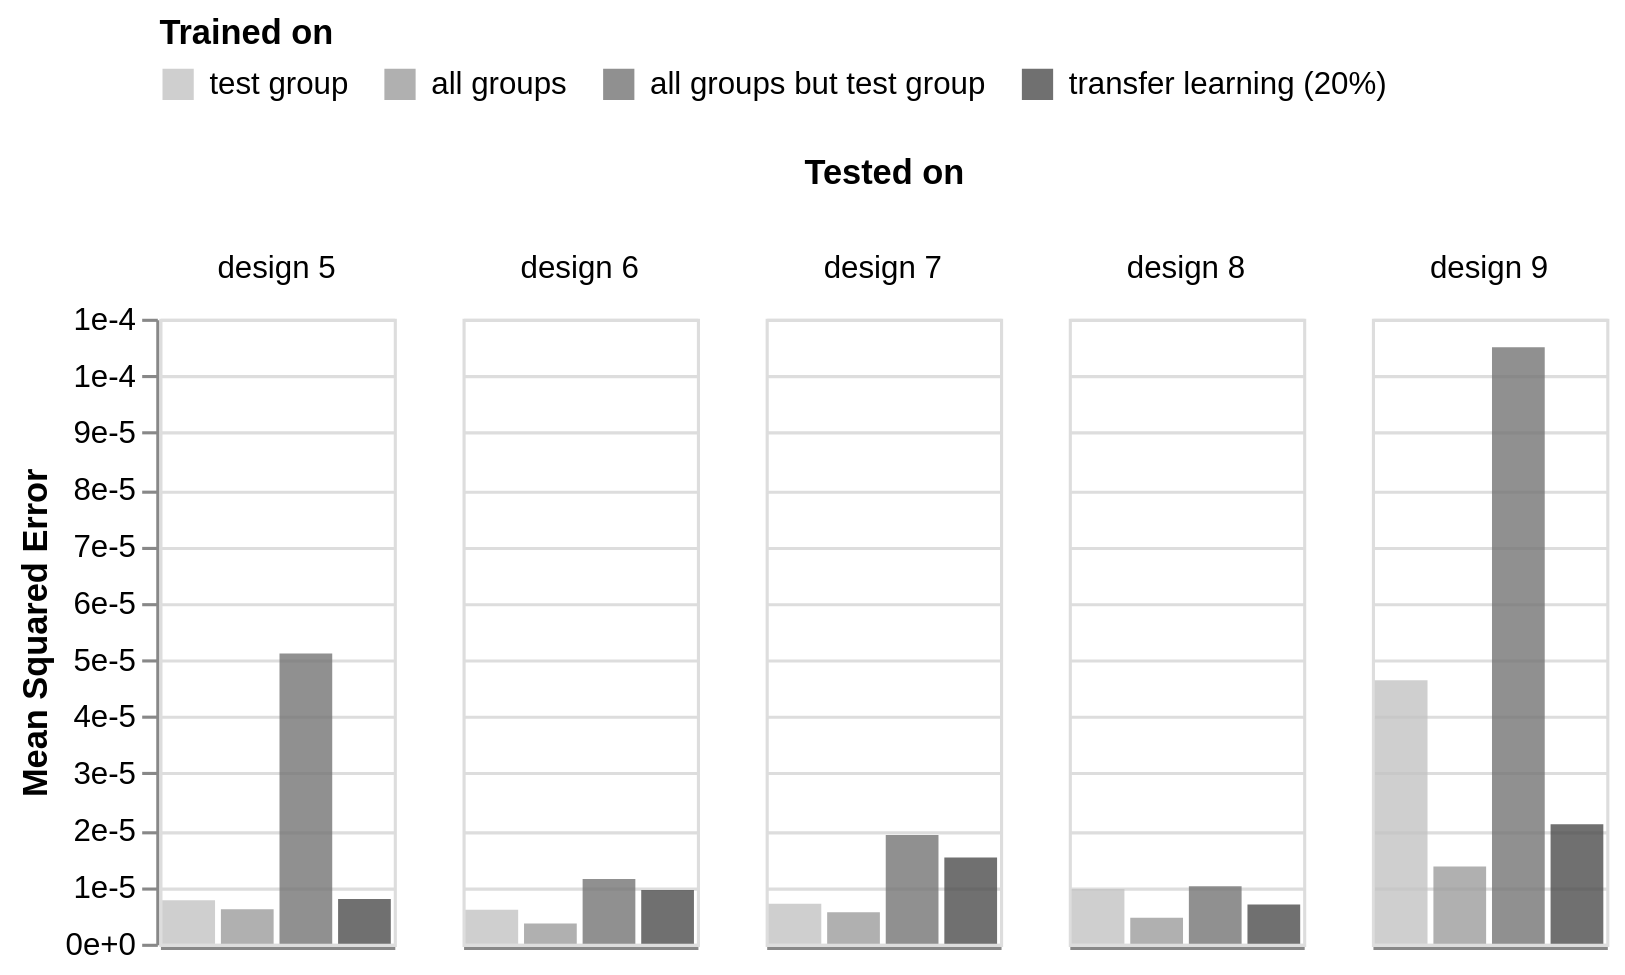

In [125]:
df['Tested on'] = df['Tested on'].str.replace('_', ' ')
order = ['test group', 'all groups']
barChart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mse):Q', axis=alt.Axis(tickCount=8, format=".0e"), title='Mean Squared Error'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='top'), scale=alt.Scale(scheme='greys')),
    opacity = alt.OpacityValue(0.8),
    tooltip='mean(mse):Q'
).properties(width=75, height=200)

fig = alt.layer(barChart, data=df).facet(
    column=alt.Column('Tested on:N'))
saveAsImage(fig, 'figures/multiTopologyStudy.png', widthInches=3.25, dpi=500)

In [107]:
order = ['test group', 'all groups']
barChart = alt.Chart(df[df['Trained on']!='transfer learning (20%)']).mark_bar().encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mse):Q', axis=alt.Axis(tickCount=8, format=".0e"), title='MSE'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
    tooltip='mean(mse):Q'
).properties(width=75, height=200)

alt.layer(barChart, data=df).facet(
    column=alt.Column('Tested on:N'))

alt.FacetChart(...)

In [108]:
df[df['Trained on']!='transfer learning (20%)']

mse       mae       mre     maxAE  mae/peak  maxAE/peak  \
0     5.136189e-07  0.000499  0.036421  0.002165  0.044146    0.191644   
1     3.477456e-06  0.001232  0.064833  0.005020  0.053574    0.218287   
2     3.468740e-06  0.001382  0.063073  0.004310  0.035244    0.109884   
3     8.189586e-06  0.002268  0.061136  0.006358  0.033929    0.095137   
4     1.158727e-06  0.000793  0.057629  0.002872  0.081044    0.293547   
...            ...       ...       ...       ...       ...         ...   
2695  1.252947e-05  0.002411  0.109207  0.010545  0.094206    0.412077   
2696  2.962537e-04  0.014306  0.252882  0.036265  0.129365    0.327928   
2697  5.179335e-05  0.005061  0.182629  0.019074  0.222069    0.836931   
2698  2.338490e-05  0.003733  0.127456  0.014864  0.098407    0.391797   
2699  7.843018e-05  0.006601  0.199432  0.019237  0.156465    0.455965   

      relEAtPeak                 Trained on Tested on  
0       0.191643                 test group  design_5  
1       0.180812                 test group  design_5  
2       0.036755                 test group  design_5  
3       0.095137                 test group  design_5  
4       0.214074                 test group  design_5  
...          ...                        ...       ...  
2695    0.061263  all groups but test group  design_9  
2696    0.176968  all groups but test group  design_9  
2697    0.256730  all groups but test group  design_9  
2698    0.391797  all groups but test group  design_9  
2699    0.045131  all groups but test group  design_9  

[2700 rows x 9 columns]

# TL across topologies

image size: (1625, 1009)


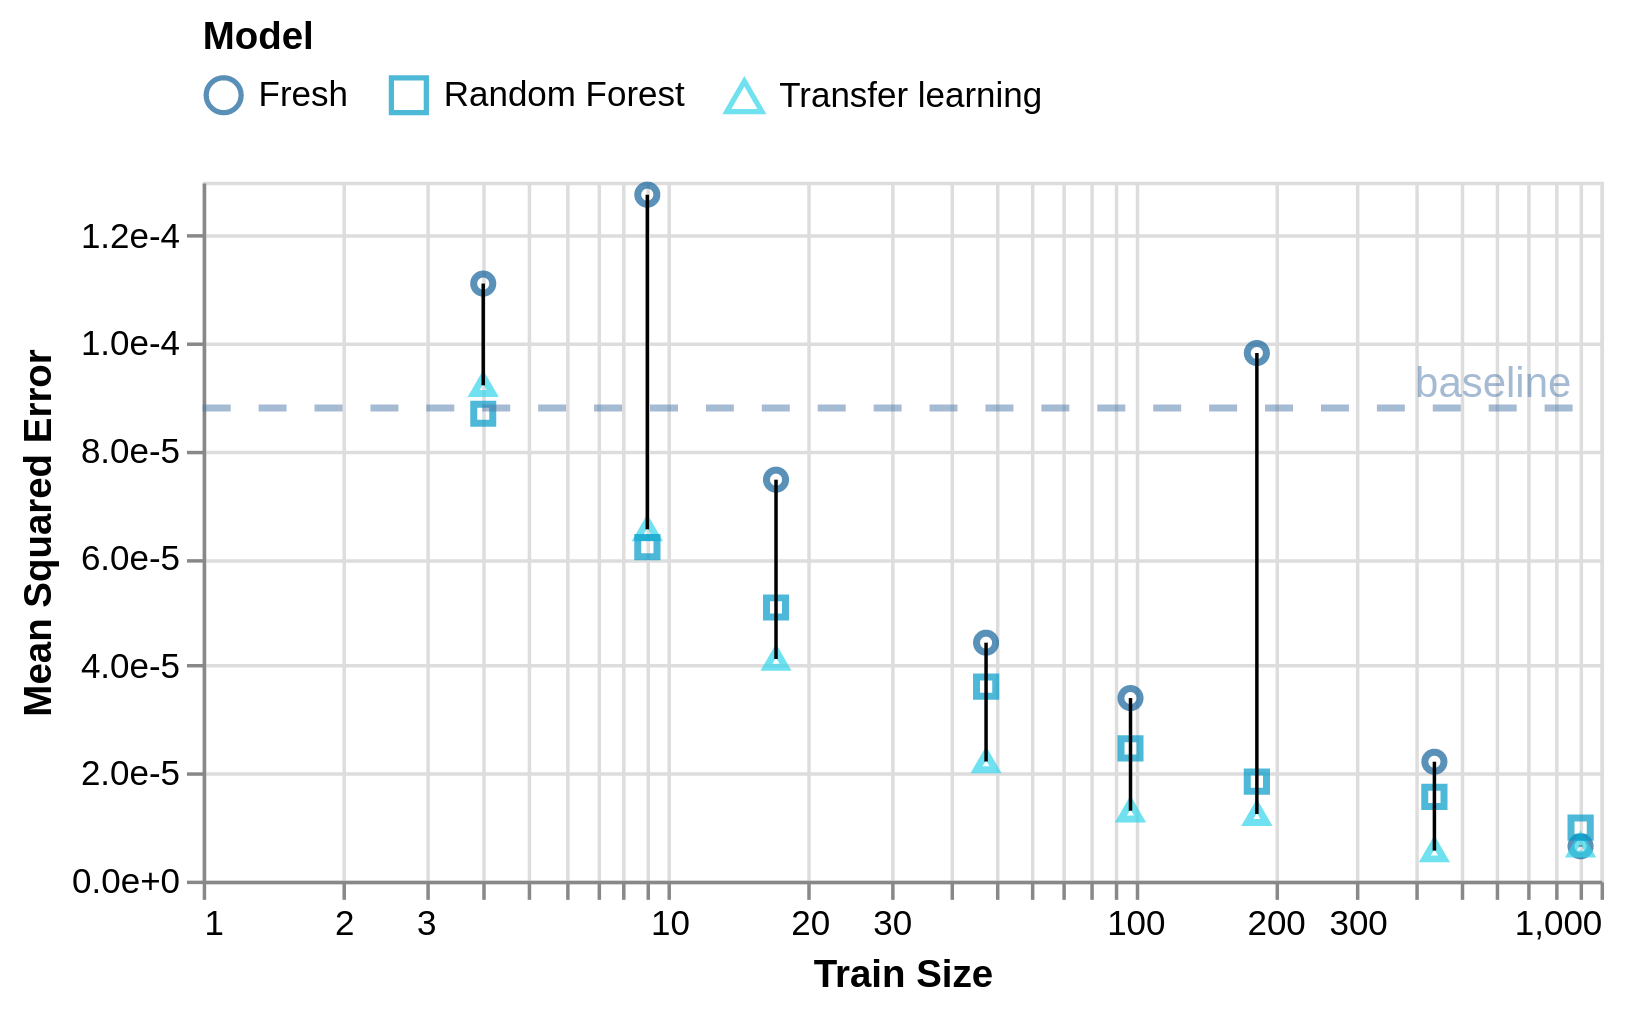

In [118]:
df = pd.read_csv('results/transferLrn_des7_03/testResults.csv')
dfFresh = df.loc[(df['Model']=='Fresh') & (df['Set']=='Test'), ['mse','Train Size']]
dfTL = df.loc[(df['Model']=='Transfer learning') & (df['Set']=='Test'), ['mse','Train Size']]
dfComb = dfFresh.merge(dfTL, on='Train Size', suffixes=['_fresh', '_tl'])

# read study data and build scatter plot
lines = alt.Chart(dfComb).mark_rule().encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse_fresh:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
    y2=alt.Y2('mse_tl:Q')).properties(width=400, height=200)

fig = alt.Chart(df[(df.Set=='Test')]).mark_point().encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
    color=alt.Color('Model', scale=alt.Scale(scheme='darkblue'), legend=alt.Legend(orient='top')),
    shape='Model',
    tooltip=['Model', 'mse']).properties(width=400, height=200)

baseline = alt.Chart(pd.DataFrame({'Train Size':[1,1000], 'mse':[base['mse']]*2})).mark_line(opacity=0.5, strokeDash=[8,8]).encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q'),
)

baselineLabel = alt.Chart(pd.DataFrame({"text": 'baseline', 'Train Size':400, 'mse':base['mse']}, index=[0])).mark_text(
    size=12, align='left', font='Arial', baseline='bottom', color='#4C78A8', opacity=0.5).encode(
    x='Train Size',
    y='mse',
    text="text:N"
).properties(width=width)

saveAsImage(fig+lines+baseline+baselineLabel, 'figures/tlDes7.png', widthInches=3.25, dpi=500)

image size: (1625, 689)


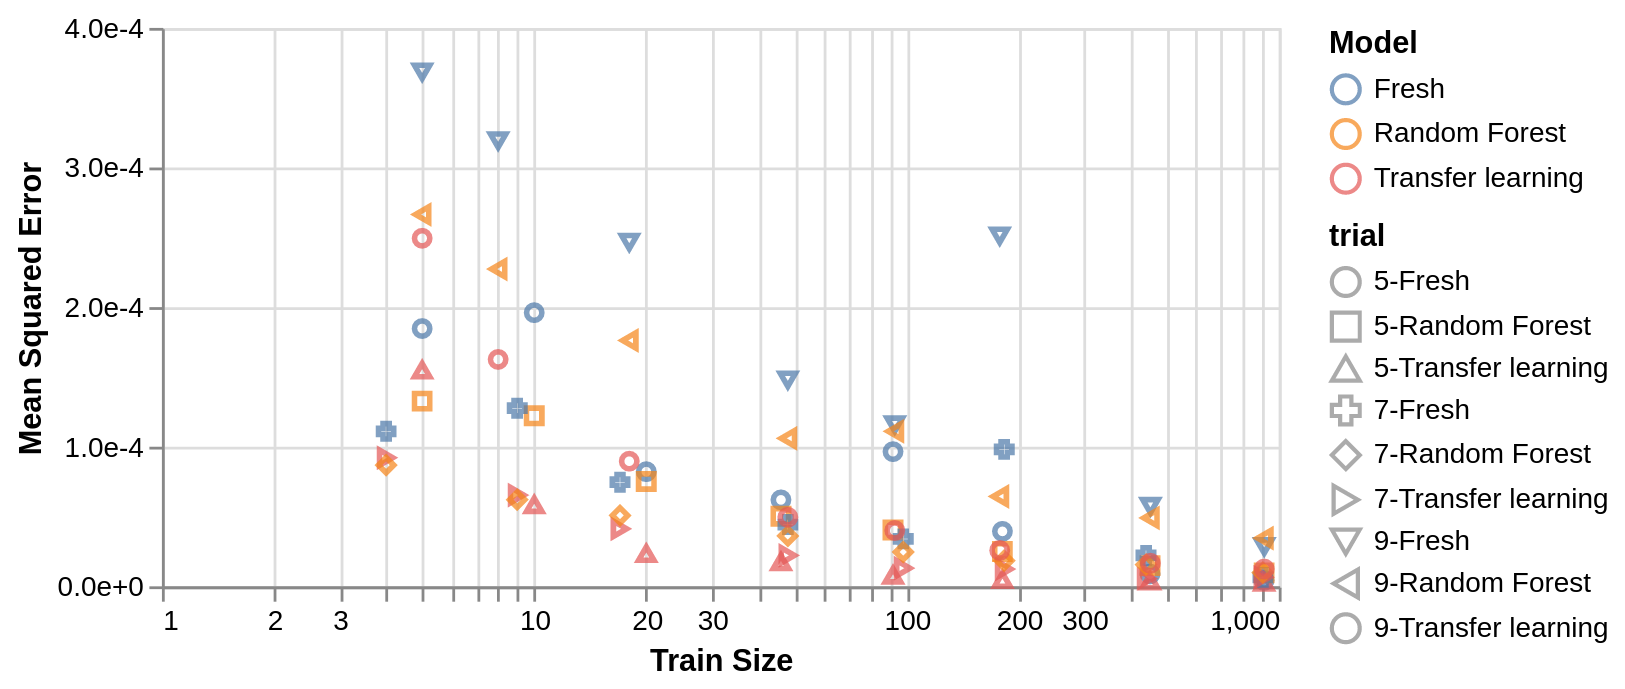

In [49]:
df5 = pd.read_csv('results/transferLrn_des5_02/testResults.csv')
df5['Group'] = 5
df7 = pd.read_csv('results/transferLrn_des7_03/testResults.csv')
df7['Group'] = 7
df9 = pd.read_csv('results/transferLrn_des9_02/testResults.csv')
df9['Group'] = 9
df = pd.concat([df5, df7, df9])

# read study data and build scatter plot
fig = alt.Chart(df[(df.Set=='Test')]).transform_calculate(
    trial="datum.Group + '-' + datum.Model").mark_point().encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
    color=alt.Color('Model:N', scale=alt.Scale(), legend=alt.Legend()),
    shape='trial:N',
    tooltip=['Model', 'mse']).properties(width=400, height=200)

saveAsImage(fig, 'figures/tlAllTopo.png', widthInches=3.25, dpi=500)

image size: (1624, 700)


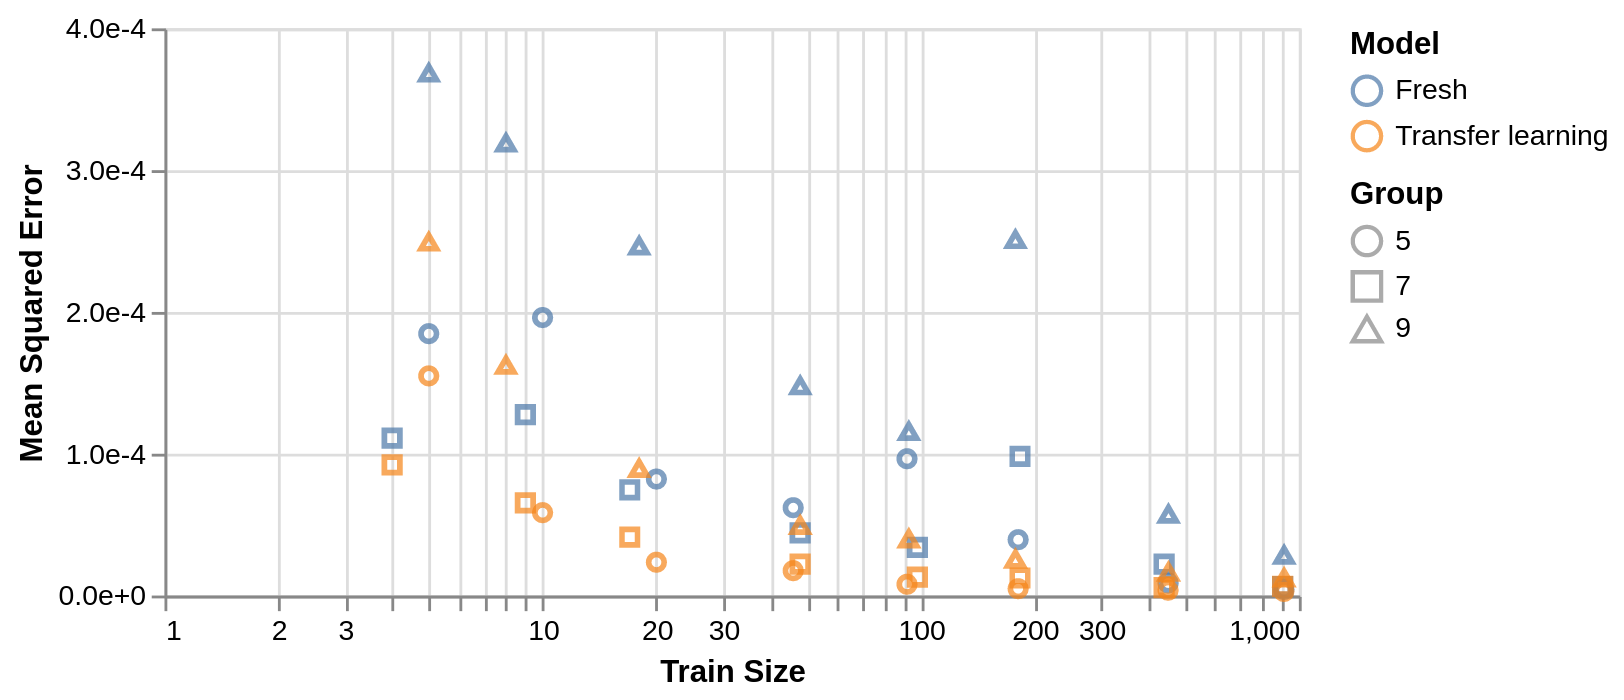

In [52]:
# read study data and build scatter plot
fig = alt.Chart(df[(df.Set=='Test') & (df.Model!='Random Forest')]).transform_calculate(
    trial="datum.Group + '-' + datum.Model").mark_point().encode(
    x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
    y=alt.Y('mse:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
    color=alt.Color('Model:N', scale=alt.Scale(), legend=alt.Legend()),
    shape='Group:N',
    tooltip=['Model', 'mse']).properties(width=400, height=200)

saveAsImage(fig, 'figures/tlAllTopo.png', widthInches=3.25, dpi=500)

In [117]:
# # load train data
# dataDir = "data/2D_Truss_v1.3/conmech/"
# trainDir = os.path.join(dataDir, 'design_7_N_1000_v2/')
# allGraphsUnfiltered = loadConmechGraphs(trainDir)
# trainData = filterbyDisp(allGraphsUnfiltered, 0.9)

# # load test data
# testDir = os.path.join(dataDir, 'design_7_N_1000/')
# allGraphsUnfiltered = loadConmechGraphs(testDir)
# testData = filterbyDisp(allGraphsUnfiltered, 0.9)

# # get baseline prediction metrics
# base = baseline([g.y.cpu().numpy() for g in trainData], 
#                 [g.y.cpu().numpy() for g in testData], 
#                 level='set', avgLevel='point')

# # read study data and build scatter plot
# df = pd.read_csv('results/transferLrn_des7_03/testResults.csv')
# fig = alt.Chart(df[(df.Set=='Test')]).mark_point().encode(
#     x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
#     y=alt.Y('mse:Q', title='Mean Squared Error', axis=alt.Axis(format='.1e')),
#     color=alt.Color('Model', scale=alt.Scale(scheme='darkblue'), legend=alt.Legend(orient='bottom')),
#     shape='Model',
#     tooltip=['Model', 'mse']).properties(width=400, height=200)
    
# line = alt.Chart(pd.DataFrame({'Train Size':[1,1000], 'mse':[base['mse']]*2})).mark_line(opacity=0.5).encode(
#     x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
#     y=alt.Y('mse:Q'),
# )

# fig = line+fig

# saveAsImage(fig, 'figures/tlDes7.png', widthInches=3.25, dpi=500)

# Endload truss

[  0.  -22.5]
[50.  0.]
image size: (1625, 899)


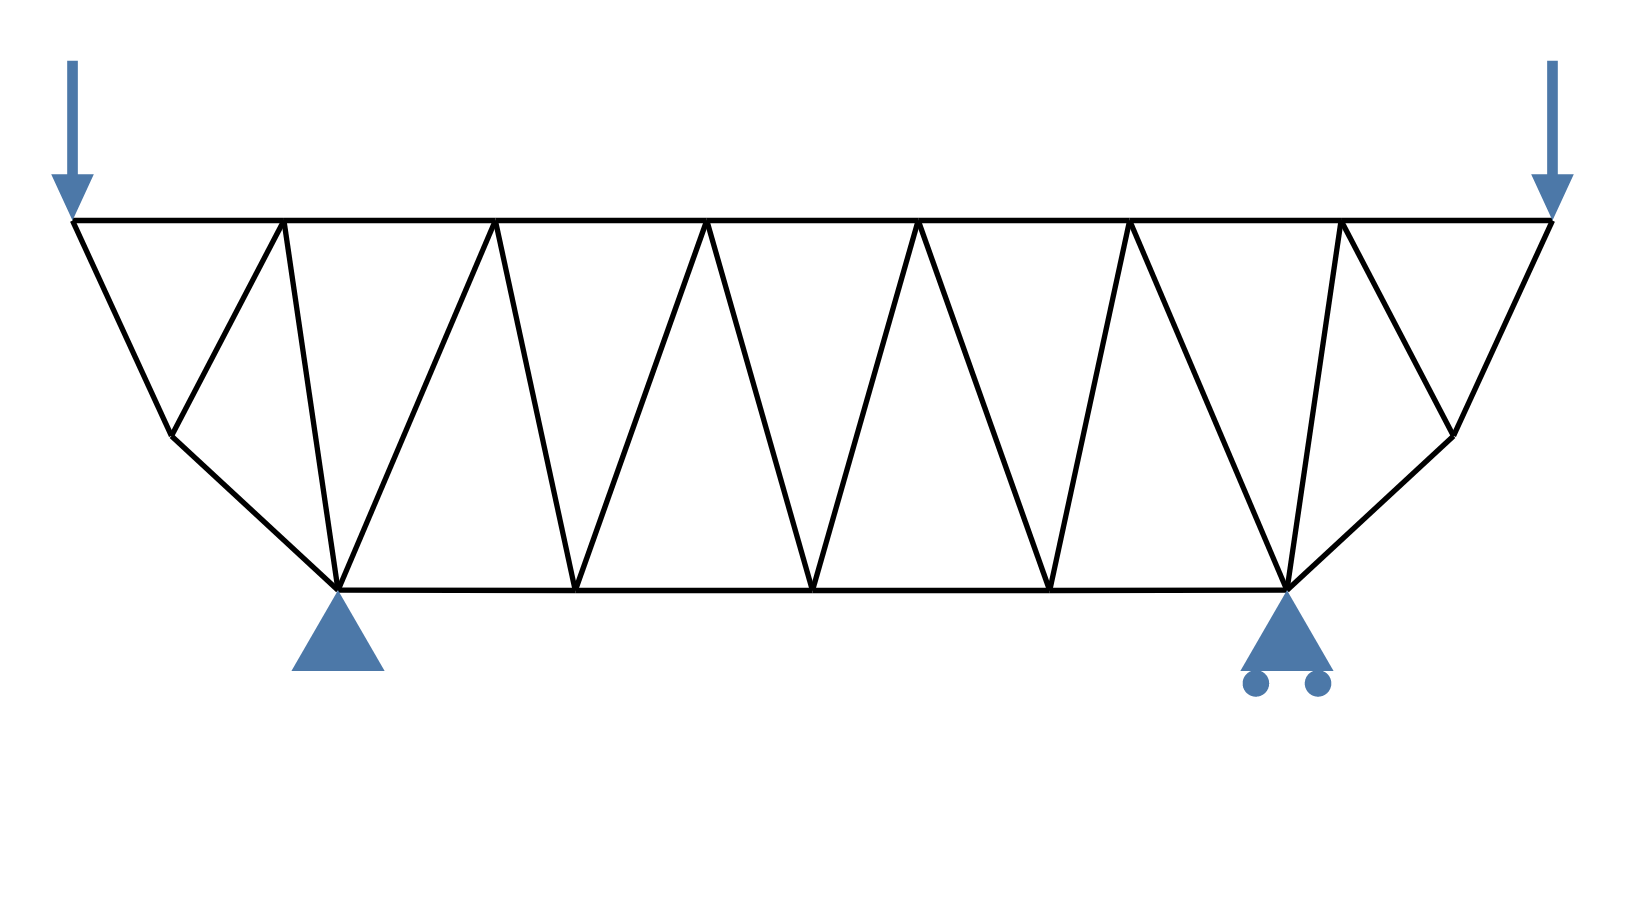

In [120]:
# load data
dataDir = 'data/endLoadsv1.0/conmech/design_7_N_5'
allGraphs = loadConmechGraphs(dataDir)

allPts = np.concatenate([g.pos.numpy() for g in allGraphs])
print(np.min(allPts, axis=0))
print(np.max(allPts, axis=0))

# apply endload BCs to paramsweep geom 
dataDir = 'data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5'
baseGraph = loadConmechGraphs(dataDir)[2]
baseGraph.x = allGraphs[0].x

fig = plotTruss(baseGraph, 
          baseColor='#000000', 
          showSupports=True, 
          domX=[-2, 52], 
          domY=[-22.5, 7], 
          showLoads=True)

saveAsImage(fig, 'figures/endloads.png', widthInches=3.25, dpi=500)

# Towers

[-10.   0.]
[30. 80.]
image size: (1625, 4180)


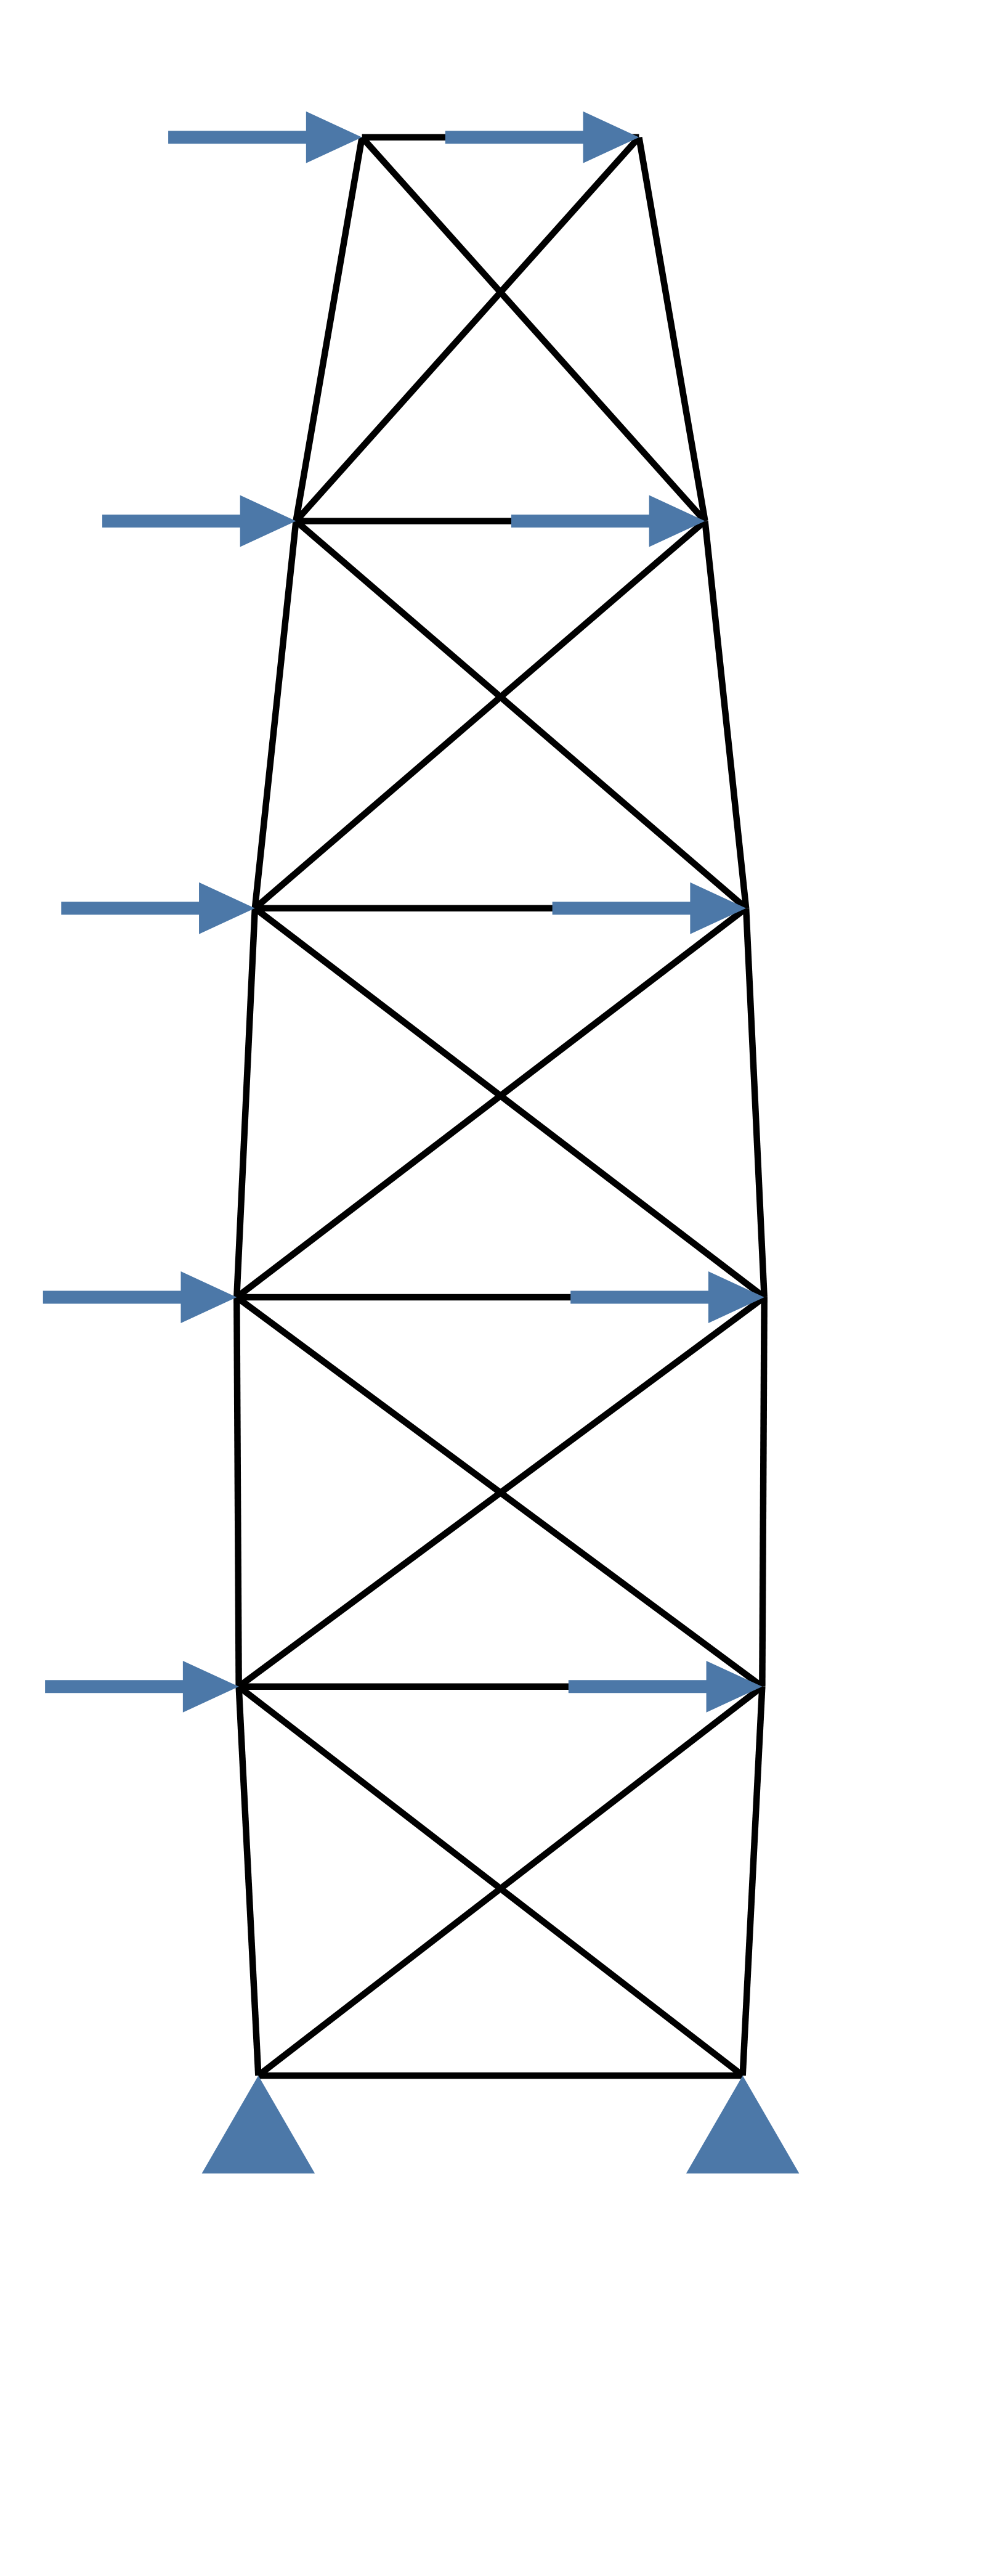

In [122]:
# load data
dataDir = 'data/tower1.0/conmech/design_5_N_1000/'
allGraphs = loadConmechGraphs(dataDir, loadDims=[0])
# allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
# trainData, valData, testData = partitionGraphList(allGraphs)

allPts = np.concatenate([g.pos.numpy() for g in allGraphs])
print(np.min(allPts, axis=0))
print(np.max(allPts, axis=0))

fig = plotTruss(allGraphs[0], 
          width=300, 
          baseColor='#000000', 
          showSupports=True, 
          domX=[-10, 30], 
          domY=[-20, 85], 
          showLoads=True, 
          loadTheta=0)

saveAsImage(fig, 'figures/tower.png', widthInches=3.25, dpi=500)

image size: (1625, 1269)


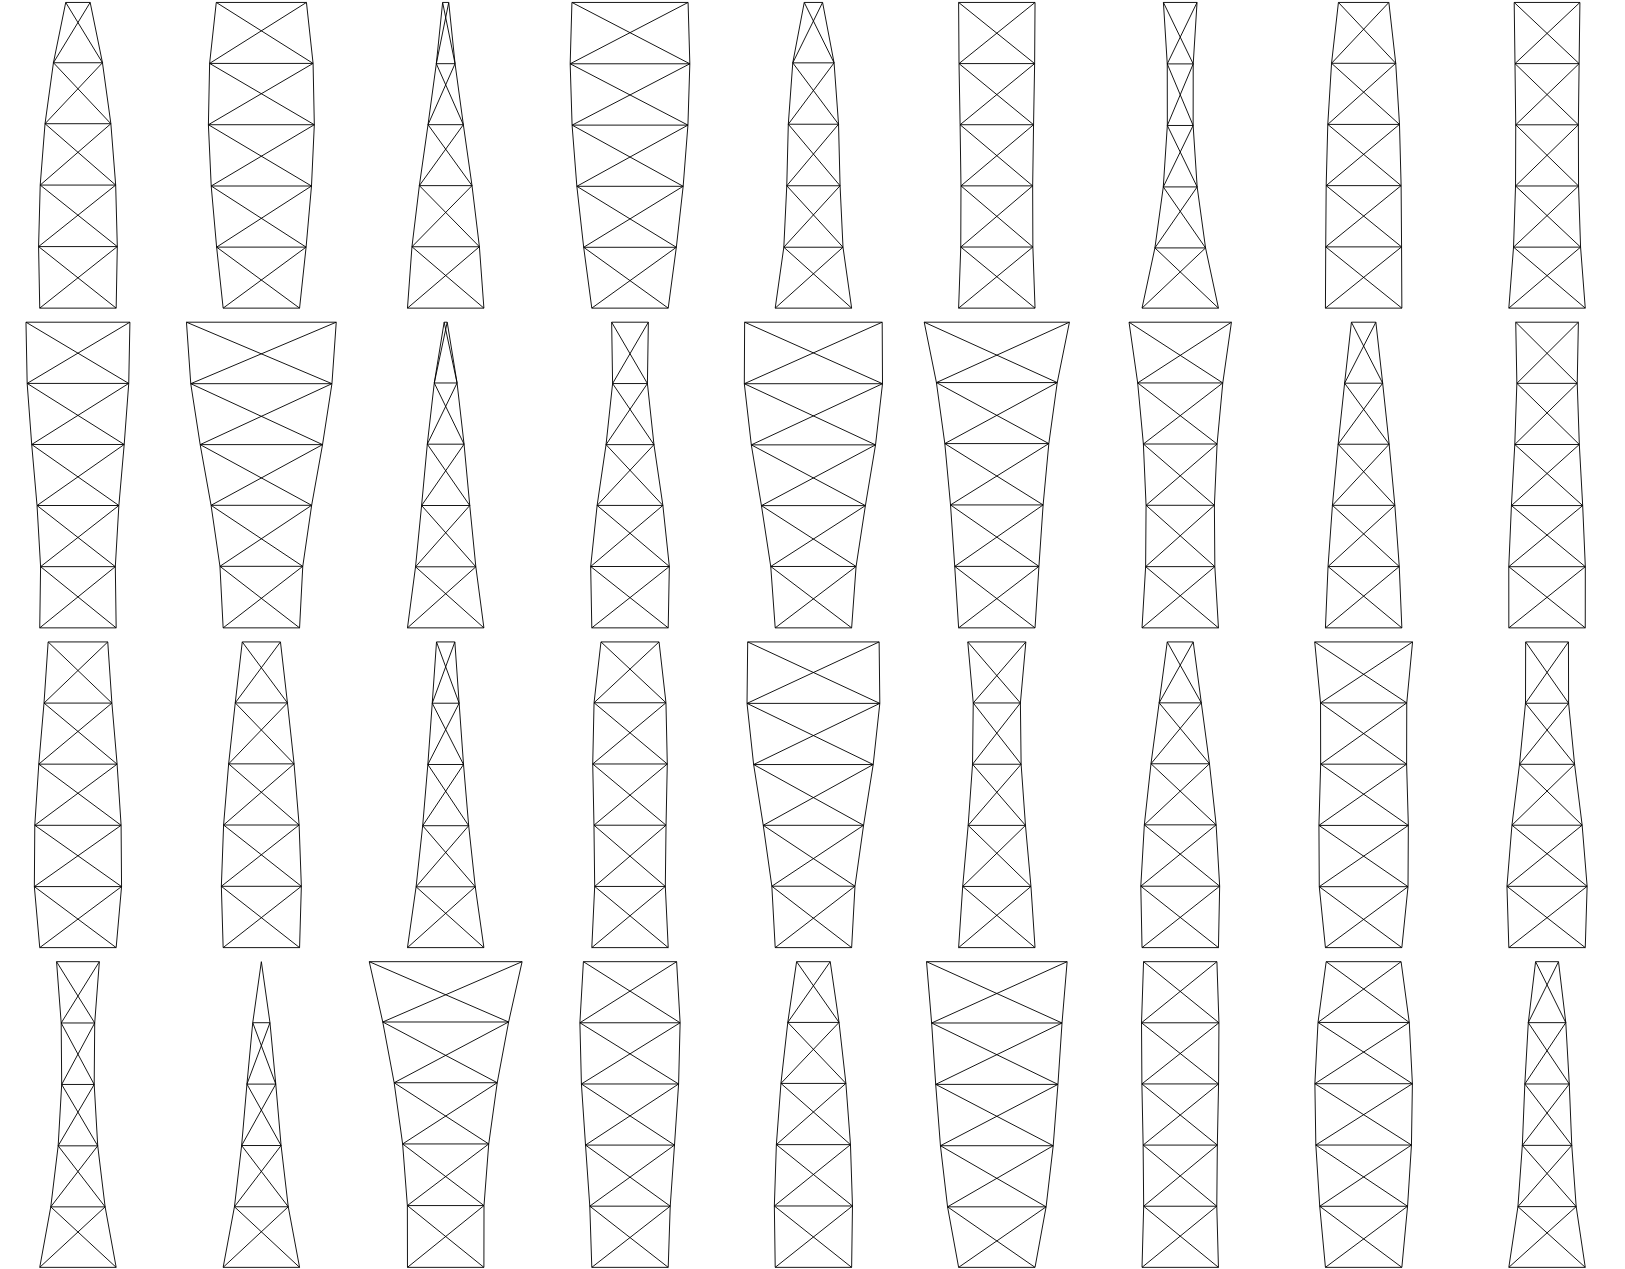

In [4]:
nModels = 36
nRows = 4
plotList = [plotTruss(g, 
                      width=500, 
                      domX=[-10,30], 
                      domY=[30,80], 
                      lineWidth=3, 
                      withoutConfigure=True, 
                      baseColor='#000000') for g in allGraphs[:nModels]]
columnList = [alt.vconcat(*plotList[nRows*i:nRows*(i+1)], spacing=40) for i in range(int(nModels/nRows))]
fig = alt.hconcat(*columnList, spacing=100, background='white').configure_view(strokeOpacity=0)

saveAsImage(fig, 'figures/tower5Samples.png', widthInches=3.25, dpi=500)